<a href="https://colab.research.google.com/github/Shidrry/Chestnut-Picking/blob/main/Chart_Reading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance
!pip install mplfinance

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import random
import datetime
import mplfinance as mpf
import time
import matplotlib.dates as mdates

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
nikkei_plus = pd.read_csv('/content/drive/MyDrive/nikkei+.csv', header=None, names=['code'])

In [ ]:
code_list = nikkei_plus['code'].tolist()

In [ ]:
def get_data_from_yfinance(ticker, start_date, end_date):
    data = yf.download(ticker+'.T', start=start_date, end=end_date, progress=False)
    data.columns = data.columns.get_level_values(0)
    data = data[['Open', 'High', 'Low', 'Close', 'Volume']]  # 必要な列を選択
    return data

In [ ]:
def calculate_atr(data, period=14):
    high_low = data['High'] - data['Low']
    high_close = np.abs(data['High'] - data['Close'].shift())
    low_close = np.abs(data['Low'] - data['Close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = np.max(ranges, axis=1)
    atr = true_range.rolling(window=period).mean()
    return atr

In [ ]:
def add_moving_averages(data):
    data['MA5'] = data['Close'].rolling(window=5).mean()
    data['MA10'] = data['Close'].rolling(window=10).mean()
    data['MA20'] = data['Close'].rolling(window=20).mean()
    return data

In [ ]:
def plot_candlestick(data, include_atr=False, atr_series=None, highlight_start=None, highlight_end=None):
    apds = []
    if include_atr and atr_series is not None:
        atr_plot = atr_series.loc[data.index]  # ATRデータの範囲を調整
        apds.append(mpf.make_addplot(atr_plot, type='line', color='fuchsia', ylabel='ATR', linestyle='-', width=0.75))

    # 移動平均線の追加
    apds.append(mpf.make_addplot(data['MA5'], color='blue', linestyle='solid', width=0.75))
    apds.append(mpf.make_addplot(data['MA10'], color='orange', linestyle='solid', width=0.75))
    apds.append(mpf.make_addplot(data['MA20'], color='green', linestyle='solid', width=0.75))

    if highlight_start and highlight_end:
        where_values = (data.index >= highlight_start) & (data.index <= highlight_end)
        y1_value = data['High'].max()
        y2_value = data['Low'].min()
        kwargs = {'fill_between': dict(y1=y1_value, y2=y2_value, where=where_values, color='gray', alpha=0.3)}
    else:
        kwargs = {}

    # 日付フォーマットを設定
    datetime_format = '%Y%m%d'

    # プロット実行
    mpf.plot(data, type='candle', style='yahoo', volume=True, addplot=apds, datetime_format=datetime_format, show_nontrading=False, **kwargs)

In [ ]:
def run_prediction_cycle():
    random_stock = random.choice(code_list)
    end_date = datetime.datetime.now() - datetime.timedelta(days=60)
    start_date = end_date - datetime.timedelta(days=5*365 + 100)

    data = get_data_from_yfinance(random_stock, start_date, end_date)
    data = add_moving_averages(data)
    atr = calculate_atr(data)  # ATRを計算

    if len(data) > 120:  # データが120日以上ある場合に実行
        # ランダムな期間を選ぶ
        max_index = len(data) - 20  # 次月のデータ分を確保
        random_start = random.randint(0, max_index - 100)  # 最低100日分確保
        random_end = random_start + 80  # ランダム期間（80日分）

        data_last_three_months = data.iloc[random_start:random_end]  # ランダムに選ばれた期間
        next_month_data = data.iloc[random_end:random_end + 20]  # ランダム選択の次月データ
        combined_data = data.iloc[random_start:random_end + 20]

        plot_candlestick(data_last_three_months, include_atr=True, atr_series=atr)
        time.sleep(0.5)

        # 最新の終値とATRの表示
        current_close = data_last_three_months['Close'].iloc[-1]
        current_atr = atr.iloc[random_end - 1]
        print(f"現在の終値: {current_close:.2f}, 現在のATR値: {current_atr:.2f}")

        print("予測を入力（上昇: 1, 下降: 0）: ")
        prediction = int(input())

        plot_candlestick(combined_data, include_atr=True, atr_series=atr, highlight_start=next_month_data.index[0], highlight_end=next_month_data.index[-1])

        initial_price = next_month_data['Open'].iloc[0]
        high_price = next_month_data['High'].max()
        low_price = next_month_data['Low'].min()

        # 初期値と高値・安値の差分を表示
        high_diff = high_price - initial_price
        low_diff = initial_price - low_price
        print(f"証券コード: {random_stock}")
        print(f"初期値: {initial_price:.2f}円, 高値: {high_price:.2f}円, 安値: {low_price:.2f}円")
        print(f"高値差分: {high_diff:.2f}円, 安値差分: {low_diff:.2f}円, 閾値: {current_atr * 1.5:.2f}円")

        print("次のチャートを見る準備ができたら、Enter")
        input()

    else:
        print("データ不足")

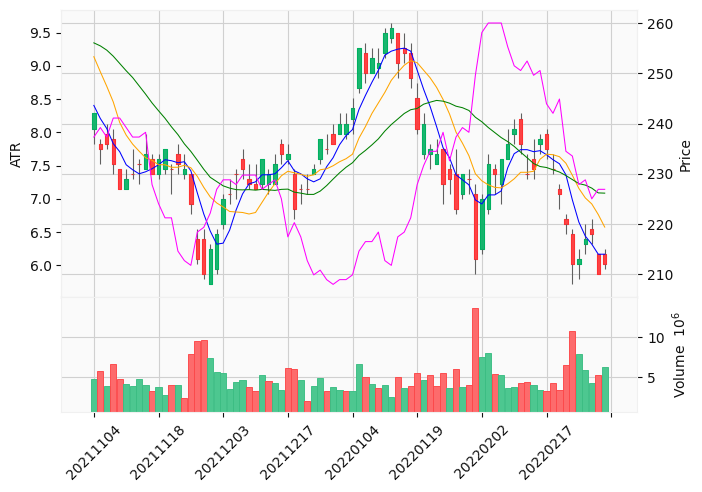

現在の終値: 212.00, 現在のATR値: 7.14
予測を入力（上昇: 1, 下降: 0）: 
0


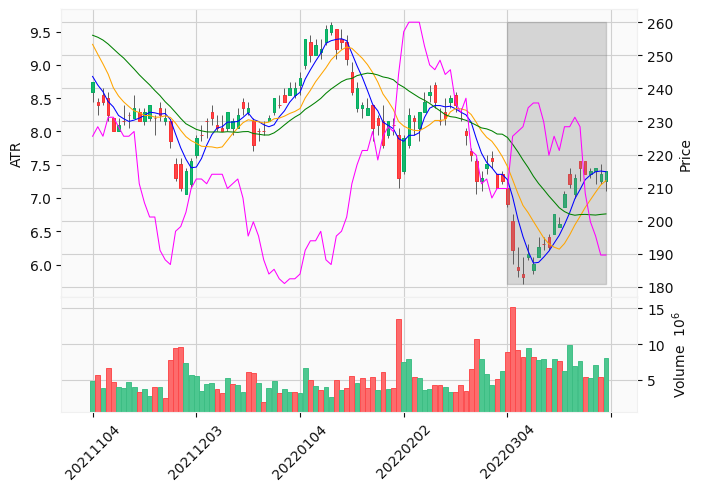

証券コード: 6472
初期値: 210.00円, 高値: 218.00円, 安値: 181.00円
高値差分: 8.00円, 安値差分: 29.00円, 閾値: 10.71円
次のチャートを見る準備ができたら、Enter


KeyboardInterrupt: Interrupted by user

In [ ]:
for _ in range(5):  # 5回繰り返す例
    run_prediction_cycle()